In [75]:
# Using Python 3.10
%pip install yfinance
%pip install scikit-learn
%pip install keras
%pip install tensorflow
%pip install py_vollib
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Obtaining dependency information for seaborn from https://files.pythonhosted.org/packages/83/11/00d3c3dfc25ad54e731d91449895a79e4bf2384dc3ac01809010ba88f6d5/seaborn-0.13.2-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 1.4 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


### Simple Model

This model uses a stacked Long Short Term Model (LSTM) architecture with dense layers. The LSTM model structure is suited for time series data. 

The input layer contains the inputs lookback and number of features.

The architecture is as follows:

1. The first LSTM layer contains 50 LSTM units with return sequences enabled, allowing it to output the full sequence.
2. A dropout layer with a rate of 0.2 follows to prevent overfitting.
3. The second LSTM layer also contains 50 LSTM units, but doesn't return sequences, outputting only the final state.
4. Another dropout layer with a rate of 0.2 is applied.
5. A dense layer with 25 units follows, acting as a fully connected layer.
6. The final output layer is a dense layer with a single unit, producing the predicted option price.

The model uses the Adam optimizer with a learning rate of 0.001 and is compiled with mean squared error as the loss function.

This architecture allows the model to capture both long-term dependencies in the time series data through the LSTM layers and make a final prediction through the dense layers.

In [76]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from py_vollib.black_scholes import black_scholes as bs
from py_vollib.black_scholes.greeks.analytical import delta, gamma, vega, theta, rho


In [77]:

def calculate_option_price_and_greeks(S, K, T, r, sigma, option_type='c'):
    price = bs(option_type, S, K, T, r, sigma)
    return {
        'price': price,
        'delta': delta(option_type, S, K, T, r, sigma),
        'gamma': gamma(option_type, S, K, T, r, sigma),
        'vega': vega(option_type, S, K, T, r, sigma),
        'theta': theta(option_type, S, K, T, r, sigma),
        'rho': rho(option_type, S, K, T, r, sigma)
    }

def prepare_data(data, lookback=30):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:(i+lookback)])
        y.append(data[i+lookback])
    return np.array(X), np.array(y)

def build_model(lookback, n_features):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(lookback, n_features)),
        Dropout(0.2),
        LSTM(32, return_sequences=False),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model


In [81]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np

def plot_training_history(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_prediction_comparison(actual_prices, dl_predictions, bs_prices, num_samples=100):
    plt.figure(figsize=(15, 8))
    
    # Sample data points
    indices = np.random.choice(len(actual_prices), num_samples, replace=False)
    
    plt.scatter(range(num_samples), actual_prices[indices], label='Actual Prices', alpha=0.7)
    plt.scatter(range(num_samples), dl_predictions[indices], label='Deep Learning Predictions', alpha=0.7)
    plt.scatter(range(num_samples), bs_prices[indices], label='Black-Scholes Prices', alpha=0.7)
    
    plt.title('Comparison of Actual Prices vs Predictions')
    plt.xlabel('Sample Index')
    plt.ylabel('Option Price')
    plt.legend()
    plt.show()

def plot_error_distribution(actual_prices, dl_predictions, bs_prices):
    dl_errors = dl_predictions - actual_prices
    bs_errors = bs_prices - actual_prices

    plt.figure(figsize=(12, 6))
    sns.kdeplot(dl_errors, label='Deep Learning Errors', shade=True)
    sns.kdeplot(bs_errors, label='Black-Scholes Errors', shade=True)
    plt.title('Error Distribution: Deep Learning vs Black-Scholes')
    plt.xlabel('Error')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

def print_model_metrics(actual_prices, dl_predictions, bs_prices):
    dl_mse = np.mean((dl_predictions - actual_prices) ** 2)
    bs_mse = np.mean((bs_prices - actual_prices) ** 2)
    dl_rmse = np.sqrt(dl_mse)
    bs_rmse = np.sqrt(bs_mse)
    dl_mape = np.mean(np.abs((dl_predictions - actual_prices) / actual_prices)) * 100
    bs_mape = np.mean(np.abs((bs_prices - actual_prices) / actual_prices)) * 100

    print(f"Deep Learning - RMSE: {dl_rmse:.4f}, MAPE: {dl_mape:.4f}%")
    print(f"Black-Scholes - RMSE: {bs_rmse:.4f}, MAPE: {bs_mape:.4f}%")

def visualize_model_comparison(history, actual_prices, dl_predictions, bs_prices):
    plot_training_history(history)
    plot_prediction_comparison(actual_prices, dl_predictions, bs_prices)
    plot_error_distribution(actual_prices, dl_predictions, bs_prices)
    print_model_metrics(actual_prices, dl_predictions, bs_prices)

In [82]:
def predict_option_prices(tickers, start_date="2010-01-01", end_date="2023-01-01"):
    all_data = []
    for ticker in tickers:
        try:
            stock_data = yf.download(ticker, start=start_date, end=end_date)
            stock_data.index = stock_data.index.tz_localize(None)
            print(f"Downloaded {len(stock_data)} days of stock data for {ticker}")

            ticker_obj = yf.Ticker(ticker)
            expirations = ticker_obj.options

            all_options = []
            for exp in expirations:
                opt = ticker_obj.option_chain(exp).calls
                opt['expirationDate'] = pd.to_datetime(exp)
                all_options.append(opt)

            if not all_options:
                print(f"No options data available for {ticker}")
                continue

            calls = pd.concat(all_options, ignore_index=True)
            calls['Date'] = pd.to_datetime(calls['lastTradeDate']).dt.tz_localize(None)
            print(f"Downloaded {len(calls)} call options for {ticker}")

            calls = calls.sort_values('Date')
            df = pd.merge_asof(stock_data.reset_index(), calls, left_on='Date', right_on='Date', direction='nearest')
            print(f"After merging, {len(df)} rows remain for {ticker}")

            if df.empty or len(df) < 21:
                print(f"Skipping {ticker} due to insufficient data (less than 21 rows).")
                continue

            df['underlying_price'] = df['Close']
            df['strike_price'] = df['strike']
            df['time_to_expiry'] = (df['expirationDate'] - df['Date']).dt.days / 365
            df['risk_free_rate'] = 0.01
            df['implied_volatility'] = df['impliedVolatility']
            df['actual_price'] = df['lastPrice']

            df.dropna(inplace=True)
            print(f"After dropping NaN values, {len(df)} rows remain for {ticker}")

            if df.empty or len(df) < 21:
                print(f"Skipping {ticker} after processing due to insufficient data (less than 21 rows).")
                continue

            bs_results = df.apply(lambda row: calculate_option_price_and_greeks(
                row['underlying_price'], row['strike_price'], row['time_to_expiry'],
                row['risk_free_rate'], row['implied_volatility']), axis=1)

            df['bs_price'] = bs_results.apply(lambda x: x['price'])
            df['delta'] = bs_results.apply(lambda x: x['delta'])
            df['gamma'] = bs_results.apply(lambda x: x['gamma'])
            df['vega'] = bs_results.apply(lambda x: x['vega'])
            df['theta'] = bs_results.apply(lambda x: x['theta'])
            df['rho'] = bs_results.apply(lambda x: x['rho'])

            features = ['underlying_price', 'strike_price', 'time_to_expiry', 'risk_free_rate', 'implied_volatility', 'delta', 'gamma', 'vega', 'theta', 'rho']
            target = 'actual_price'

            scaler = StandardScaler()
            df[features + [target]] = scaler.fit_transform(df[features + [target]])
            all_data.append(df[features + [target]].values)

        except Exception as e:
            print(f"Failed to process data for {ticker}: {e}")
            continue

    if not all_data:
        raise ValueError("No valid data to train the model.")

    combined_data = np.concatenate(all_data, axis=0)
    X, y = prepare_data(combined_data, lookback=30)
    y = y[:, -1]

    X = np.nan_to_num(X, nan=0, posinf=1e6, neginf=-1e6)
    y = np.nan_to_num(y, nan=0, posinf=1e6, neginf=-1e6)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    print(f"X shape: {X.shape}, y shape: {y.shape}")
    print(f"X mean: {np.mean(X)}, X std: {np.std(X)}")
    print(f"y mean: {np.mean(y)}, y std: {np.std(y)}")

    lookback = X.shape[1]
    n_features = X.shape[2]
    model = build_model(lookback, n_features)

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(X_train, y_train, epochs=100, batch_size=32, 
                        validation_split=0.2, verbose=1, callbacks=[early_stopping])

    print(f"Final training loss: {history.history['loss'][-1]}")
    print(f"Final validation loss: {history.history['val_loss'][-1]}")

    dl_predictions = model.predict(X_test)

    dl_predictions = scaler.inverse_transform(np.concatenate((X_test[:, -1, :-1], dl_predictions), axis=1))[:, -1]
    actual_prices = scaler.inverse_transform(np.concatenate((X_test[:, -1, :-1], y_test.reshape(-1, 1)), axis=1))[:, -1]
    bs_prices = scaler.inverse_transform(np.concatenate((X_test[:, -1, :-1], X_test[:, -1, -2].reshape(-1, 1)), axis=1))[:, -1]

    dl_rmse = np.sqrt(np.mean((dl_predictions - actual_prices) ** 2))
    bs_rmse = np.sqrt(np.mean((bs_prices - actual_prices) ** 2))
    dl_mape = np.mean(np.abs((dl_predictions - actual_prices) / actual_prices)) * 100
    bs_mape = np.mean(np.abs((bs_prices - actual_prices) / actual_prices)) * 100

    print(f"Deep Learning RMSE: {dl_rmse}")
    print(f"Black-Scholes RMSE: {bs_rmse}")
    print(f"Deep Learning MAPE: {dl_mape}%")
    print(f"Black-Scholes MAPE: {bs_mape}%")

    return model, history, dl_predictions, bs_prices, actual_prices

[*********************100%***********************]  1 of 1 completed


Downloaded 3272 days of stock data for AAPL


[*********************100%***********************]  1 of 1 completed

Downloaded 990 call options for AAPL
After merging, 3272 rows remain for AAPL
After dropping NaN values, 3272 rows remain for AAPL
Downloaded 3272 days of stock data for MSFT



[*********************100%***********************]  1 of 1 completed

Downloaded 1524 call options for MSFT
After merging, 3272 rows remain for MSFT
After dropping NaN values, 3272 rows remain for MSFT
Downloaded 3272 days of stock data for GOOGL



[*********************100%***********************]  1 of 1 completed

Downloaded 818 call options for GOOGL
After merging, 3272 rows remain for GOOGL
After dropping NaN values, 3272 rows remain for GOOGL
Downloaded 3272 days of stock data for AMZN



[*********************100%***********************]  1 of 1 completed

Downloaded 788 call options for AMZN
After merging, 3272 rows remain for AMZN
After dropping NaN values, 3272 rows remain for AMZN
Downloaded 2673 days of stock data for META



[*********************100%***********************]  1 of 1 completed

Downloaded 2114 call options for META
After merging, 2673 rows remain for META
After dropping NaN values, 2673 rows remain for META
Downloaded 3150 days of stock data for TSLA



[*********************100%***********************]  1 of 1 completed

Downloaded 1409 call options for TSLA
After merging, 3150 rows remain for TSLA
After dropping NaN values, 0 rows remain for TSLA
Skipping TSLA after processing due to insufficient data (less than 21 rows).
Downloaded 3272 days of stock data for NVDA



/Users/john/miniconda3/envs/python310/lib/python3.10/site-packages/py_vollib/ref_python/black_scholes/__init__.py:87: RuntimeWarning: divide by zero encountered in scalar divide
  return numerator / denominator
/Users/john/miniconda3/envs/python310/lib/python3.10/site-packages/py_vollib/black_scholes/greeks/analytical.py:190: RuntimeWarning: invalid value encountered in scalar divide
  return pdf(d_1)/(S*sigma*numpy.sqrt(t))
/Users/john/miniconda3/envs/python310/lib/python3.10/site-packages/sklearn/utils/extmath.py:1051: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/john/miniconda3/envs/python310/lib/python3.10/site-packages/sklearn/utils/extmath.py:1056: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/john/miniconda3/envs/python310/lib/python3.10/site-packages/sklearn/utils/extmath.py:1076: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_varianc

Downloaded 5790 call options for NVDA
After merging, 3272 rows remain for NVDA
After dropping NaN values, 3272 rows remain for NVDA







































































































































































































































































































































































































































































































































































































































































































































































































































































































[*********************100%***********************]  1 of 1 completed

Downloaded 457 call options for PYPL
After merging, 1888 rows remain for PYPL
After dropping NaN values, 1888 rows remain for PYPL
Downloaded 3272 days of stock data for NFLX



[*********************100%***********************]  1 of 1 completed

Downloaded 1528 call options for NFLX
After merging, 3272 rows remain for NFLX
After dropping NaN values, 3272 rows remain for NFLX
Downloaded 3272 days of stock data for ADBE



[*********************100%***********************]  1 of 1 completed

Downloaded 869 call options for ADBE
After merging, 3272 rows remain for ADBE
After dropping NaN values, 3272 rows remain for ADBE
Downloaded 3272 days of stock data for GOOG



[*********************100%***********************]  1 of 1 completed

Downloaded 572 call options for GOOG
After merging, 3272 rows remain for GOOG
After dropping NaN values, 3272 rows remain for GOOG
Downloaded 3272 days of stock data for CSCO


Downloaded 267 call options for CSCO
After merging, 3272 rows remain for CSCO
After dropping NaN values, 3272 rows remain for CSCO


[*********************100%***********************]  1 of 1 completed


Downloaded 3272 days of stock data for PEP


[*********************100%***********************]  1 of 1 completed

Downloaded 239 call options for PEP
After merging, 3272 rows remain for PEP
After dropping NaN values, 0 rows remain for PEP
Skipping PEP after processing due to insufficient data (less than 21 rows).
Downloaded 3272 days of stock data for AVGO



/Users/john/miniconda3/envs/python310/lib/python3.10/site-packages/py_vollib/ref_python/black_scholes/__init__.py:87: RuntimeWarning: divide by zero encountered in scalar divide
  return numerator / denominator
/Users/john/miniconda3/envs/python310/lib/python3.10/site-packages/py_vollib/black_scholes/greeks/analytical.py:190: RuntimeWarning: invalid value encountered in scalar divide
  return pdf(d_1)/(S*sigma*numpy.sqrt(t))
/Users/john/miniconda3/envs/python310/lib/python3.10/site-packages/sklearn/utils/extmath.py:1051: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/john/miniconda3/envs/python310/lib/python3.10/site-packages/sklearn/utils/extmath.py:1056: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/john/miniconda3/envs/python310/lib/python3.10/site-packages/sklearn/utils/extmath.py:1076: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_varianc

Downloaded 2649 call options for AVGO
After merging, 3272 rows remain for AVGO
After dropping NaN values, 3272 rows remain for AVGO







































































































































































































































































































































































































































































































































































































































































































































































































































































































[*********************100%***********************]  1 of 1 completed

Downloaded 1201 call options for COST
After merging, 3272 rows remain for COST
After dropping NaN values, 3272 rows remain for COST
Downloaded 3272 days of stock data for TXN



[*********************100%***********************]  1 of 1 completed

Downloaded 383 call options for TXN
After merging, 3272 rows remain for TXN
After dropping NaN values, 0 rows remain for TXN
Skipping TXN after processing due to insufficient data (less than 21 rows).
Downloaded 3272 days of stock data for QCOM



[*********************100%***********************]  1 of 1 completed

Downloaded 505 call options for QCOM
After merging, 3272 rows remain for QCOM
After dropping NaN values, 0 rows remain for QCOM
Skipping QCOM after processing due to insufficient data (less than 21 rows).
Downloaded 3272 days of stock data for INTC



[*********************100%***********************]  1 of 1 completed

Downloaded 524 call options for INTC
After merging, 3272 rows remain for INTC
After dropping NaN values, 3272 rows remain for INTC
Downloaded 3272 days of stock data for HON



[*********************100%***********************]  1 of 1 completed

Downloaded 226 call options for HON
After merging, 3272 rows remain for HON
After dropping NaN values, 3272 rows remain for HON
Downloaded 3272 days of stock data for AMAT



[*********************100%***********************]  1 of 1 completed

Downloaded 504 call options for AMAT
After merging, 3272 rows remain for AMAT
After dropping NaN values, 3272 rows remain for AMAT
Downloaded 3272 days of stock data for AMD



[*********************100%***********************]  1 of 1 completed

Downloaded 889 call options for AMD
After merging, 3272 rows remain for AMD
After dropping NaN values, 3272 rows remain for AMD
Downloaded 3272 days of stock data for AMGN



[*********************100%***********************]  1 of 1 completed

Downloaded 410 call options for AMGN
After merging, 3272 rows remain for AMGN
After dropping NaN values, 0 rows remain for AMGN
Skipping AMGN after processing due to insufficient data (less than 21 rows).
Downloaded 3272 days of stock data for SBUX



[*********************100%***********************]  1 of 1 completed

Downloaded 398 call options for SBUX
After merging, 3272 rows remain for SBUX
After dropping NaN values, 3272 rows remain for SBUX
Downloaded 1024 days of stock data for MRNA



[*********************100%***********************]  1 of 1 completed

Downloaded 514 call options for MRNA
After merging, 1024 rows remain for MRNA
After dropping NaN values, 1024 rows remain for MRNA
Downloaded 3272 days of stock data for INTU



[*********************100%***********************]  1 of 1 completed

Downloaded 568 call options for INTU
After merging, 3272 rows remain for INTU
After dropping NaN values, 32 rows remain for INTU
Downloaded 3272 days of stock data for ISRG



[*********************100%***********************]  1 of 1 completed

Downloaded 454 call options for ISRG
After merging, 3272 rows remain for ISRG
After dropping NaN values, 3272 rows remain for ISRG
Downloaded 3272 days of stock data for BKNG



[*********************100%***********************]  1 of 1 completed

Downloaded 1160 call options for BKNG
After merging, 3272 rows remain for BKNG
After dropping NaN values, 3226 rows remain for BKNG
Downloaded 3272 days of stock data for ADI



[*********************100%***********************]  1 of 1 completed

Downloaded 268 call options for ADI
After merging, 3272 rows remain for ADI
After dropping NaN values, 0 rows remain for ADI
Skipping ADI after processing due to insufficient data (less than 21 rows).
Downloaded 3272 days of stock data for MDLZ



[*********************100%***********************]  1 of 1 completed

Downloaded 171 call options for MDLZ
After merging, 3272 rows remain for MDLZ
After dropping NaN values, 3272 rows remain for MDLZ
Downloaded 3272 days of stock data for LRCX



[*********************100%***********************]  1 of 1 completed

Downloaded 996 call options for LRCX
After merging, 3272 rows remain for LRCX
After dropping NaN values, 25 rows remain for LRCX
Downloaded 3272 days of stock data for GILD



[*********************100%***********************]  1 of 1 completed

Downloaded 253 call options for GILD
After merging, 3272 rows remain for GILD
After dropping NaN values, 0 rows remain for GILD
Skipping GILD after processing due to insufficient data (less than 21 rows).
Downloaded 3272 days of stock data for ADP



[*********************100%***********************]  1 of 1 completed

Downloaded 199 call options for ADP
After merging, 3272 rows remain for ADP
After dropping NaN values, 0 rows remain for ADP
Skipping ADP after processing due to insufficient data (less than 21 rows).
Downloaded 3272 days of stock data for VRTX



[*********************100%***********************]  1 of 1 completed

1 Failed download:
['FISV']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2023-01-01) (Yahoo error = "Data doesn\'t exist for startDate = 1262322000, endDate = 1672549200")')
[*********************100%***********************]  1 of 1 completed

Downloaded 302 call options for VRTX
After merging, 3272 rows remain for VRTX
After dropping NaN values, 3272 rows remain for VRTX
Failed to process data for FISV: 'Index' object has no attribute 'tz_localize'
Downloaded 3271 days of stock data for CHTR



[*********************100%***********************]  1 of 1 completed

Downloaded 396 call options for CHTR
After merging, 3271 rows remain for CHTR
After dropping NaN values, 0 rows remain for CHTR
Skipping CHTR after processing due to insufficient data (less than 21 rows).
Downloaded 3272 days of stock data for ADSK



[*********************100%***********************]  1 of 1 completed

Downloaded 230 call options for ADSK
After merging, 3272 rows remain for ADSK
After dropping NaN values, 3272 rows remain for ADSK
Downloaded 3272 days of stock data for TMUS



[*********************100%***********************]  1 of 1 completed

Downloaded 292 call options for TMUS
After merging, 3272 rows remain for TMUS
After dropping NaN values, 3272 rows remain for TMUS
Downloaded 3272 days of stock data for REGN



[*********************100%***********************]  1 of 1 completed

Downloaded 493 call options for REGN
After merging, 3272 rows remain for REGN
After dropping NaN values, 0 rows remain for REGN
Skipping REGN after processing due to insufficient data (less than 21 rows).
Downloaded 3272 days of stock data for MU



[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ATVI']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed

Downloaded 866 call options for MU
After merging, 3272 rows remain for MU
After dropping NaN values, 3272 rows remain for MU
Failed to process data for ATVI: 'Index' object has no attribute 'tz_localize'
Downloaded 3272 days of stock data for ILMN



[*********************100%***********************]  1 of 1 completed

Downloaded 279 call options for ILMN
After merging, 3272 rows remain for ILMN
After dropping NaN values, 3272 rows remain for ILMN
Downloaded 3272 days of stock data for CSX



[*********************100%***********************]  1 of 1 completed

Downloaded 107 call options for CSX
After merging, 3272 rows remain for CSX
After dropping NaN values, 3272 rows remain for CSX
Downloaded 3272 days of stock data for KLAC



[*********************100%***********************]  1 of 1 completed

Downloaded 366 call options for KLAC
After merging, 3272 rows remain for KLAC
After dropping NaN values, 3254 rows remain for KLAC
Downloaded 3272 days of stock data for AEP



[*********************100%***********************]  1 of 1 completed

Downloaded 145 call options for AEP
After merging, 3272 rows remain for AEP
After dropping NaN values, 0 rows remain for AEP
Skipping AEP after processing due to insufficient data (less than 21 rows).
Downloaded 3272 days of stock data for MNST



[*********************100%***********************]  1 of 1 completed

Downloaded 188 call options for MNST
After merging, 3272 rows remain for MNST
After dropping NaN values, 3272 rows remain for MNST
Downloaded 3123 days of stock data for NXPI



[*********************100%***********************]  1 of 1 completed

Downloaded 267 call options for NXPI
After merging, 3123 rows remain for NXPI
After dropping NaN values, 3123 rows remain for NXPI
Downloaded 2630 days of stock data for PANW



[*********************100%***********************]  1 of 1 completed

Downloaded 786 call options for PANW
After merging, 2630 rows remain for PANW
After dropping NaN values, 76 rows remain for PANW
Downloaded 3272 days of stock data for CTSH



[*********************100%***********************]  1 of 1 completed

Downloaded 109 call options for CTSH
After merging, 3272 rows remain for CTSH
After dropping NaN values, 3272 rows remain for CTSH
Downloaded 3272 days of stock data for EXC



[*********************100%***********************]  1 of 1 completed

Downloaded 95 call options for EXC
After merging, 3272 rows remain for EXC
After dropping NaN values, 3272 rows remain for EXC
Downloaded 3272 days of stock data for XEL


Downloaded 31 call options for XEL
After merging, 3272 rows remain for XEL
After dropping NaN values, 3272 rows remain for XEL
X shape: (106907, 30, 11), y shape: (106907,)
X mean: 8.818423530757321e-06, X std: 0.7818749890459653
y mean: -1.4489769341055995e-14, y std: 0.4289316260089237
Epoch 1/100


/Users/john/miniconda3/envs/python310/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2139/2139 ━━━━━━━━━━━━━━━━━━━━ 27s 12ms/step - loss: 0.1351 - val_loss: 0.0421
Epoch 2/100
2139/2139 ━━━━━━━━━━━━━━━━━━━━ 25s 12ms/step - loss: 0.0655 - val_loss: 0.0264
Epoch 3/100
2139/2139 ━━━━━━━━━━━━━━━━━━━━ 25s 12ms/step - loss: 0.0328 - val_loss: 0.0221
Epoch 4/100
2139/2139 ━━━━━━━━━━━━━━━━━━━━ 25s 12ms/step - loss: 0.0295 - val_loss: 0.0254
Epoch 5/100
2139/2139 ━━━━━━━━━━━━━━━━━━━━ 25s 12ms/step - loss: 0.0350 - val_loss: 0.0190
Epoch 6/100
2139/2139 ━━━━━━━━━━━━━━━━━━━━ 25s 12ms/step - loss: 0.0132 - val_loss: 0.0211
Epoch 7/100
2139/2139 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - loss: 0.0231 - val_loss: 0.0203
Epoch 8/100
2139/2139 ━━━━━━━━━━━━━━━━━━━━ 25s 12ms/step - loss: 0.0167 - val_loss: 0.0190
Epoch 9/100
2139/2139 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - loss: 0.0186 - val_loss: 0.0183
Epoch 10/100
2139/2139 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - loss: 0.0257 - val_loss: 0.0190
Epoch 11/100
2139/2139 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - loss: 0.0216 - val_loss: 0.0192
Epoch 12/

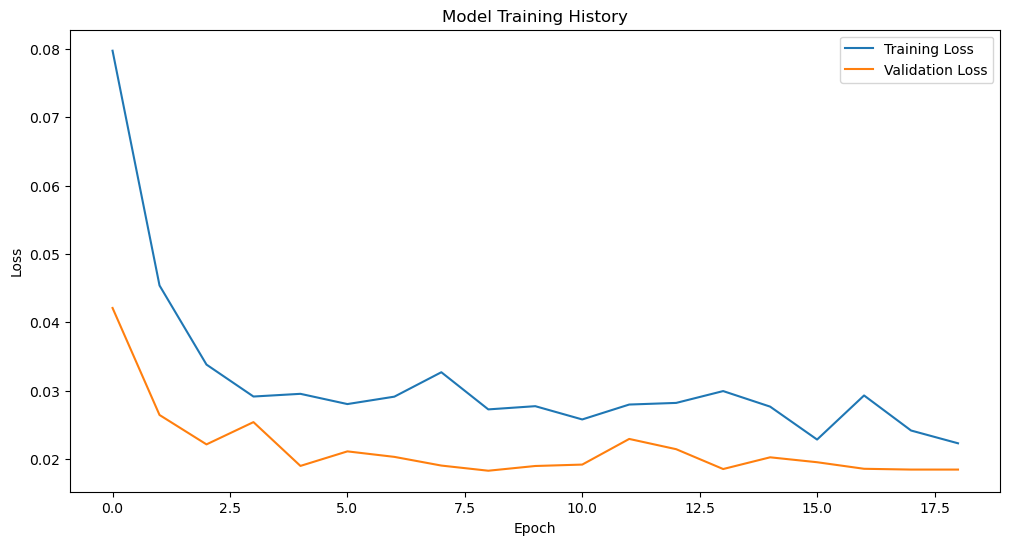

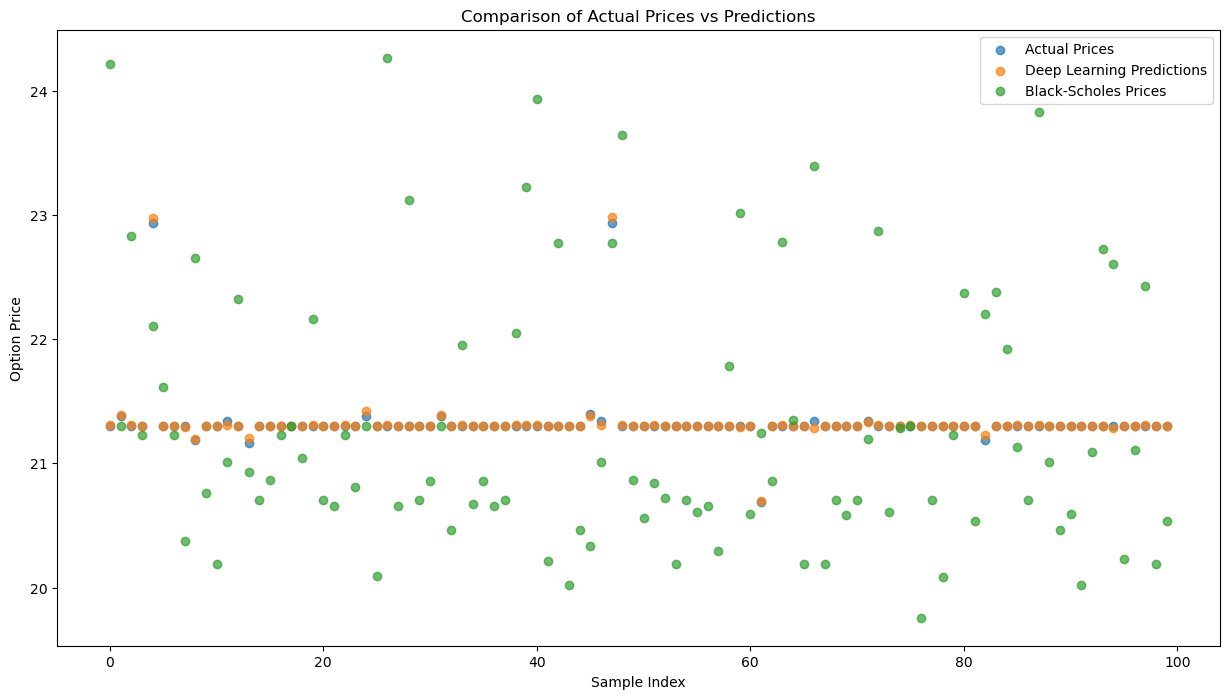

/var/folders/rj/1ckgg1qd3fx35nf_zstrzlmr0000gn/T/ipykernel_48747/1235997581.py:37: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dl_errors, label='Deep Learning Errors', shade=True)
/var/folders/rj/1ckgg1qd3fx35nf_zstrzlmr0000gn/T/ipykernel_48747/1235997581.py:38: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(bs_errors, label='Black-Scholes Errors', shade=True)


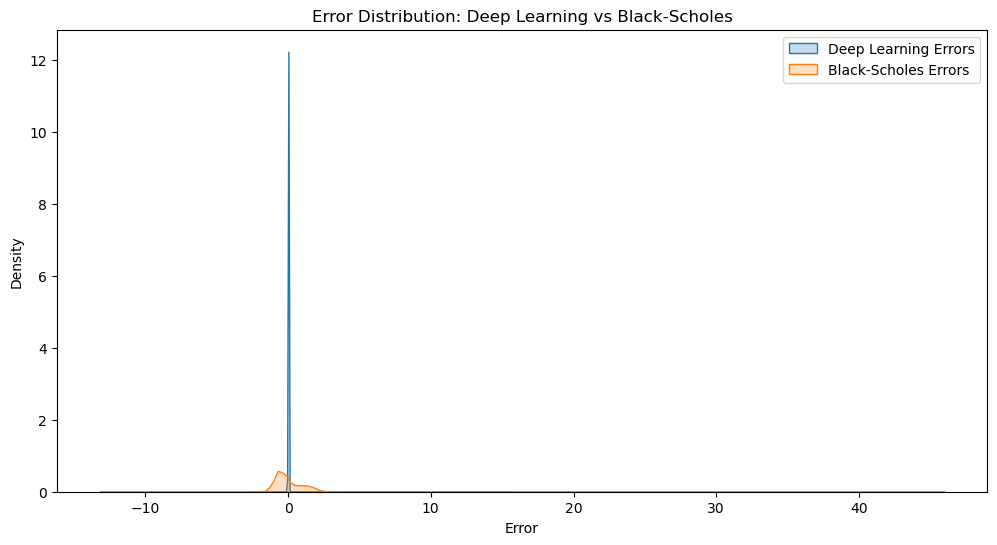

Deep Learning - RMSE: 0.1600, MAPE: 0.0650%
Black-Scholes - RMSE: 1.0803, MAPE: 3.7338%


In [84]:

nasdaq_tickers = [
    'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'TSLA', 'NVDA', 'PYPL', 'NFLX', 'ADBE',
    'GOOG', 'CSCO', 'PEP', 'AVGO', 'COST', 'TXN', 'QCOM', 'INTC', 'HON', 'AMAT',
    'AMD', 'AMGN', 'SBUX', 'MRNA', 'INTU', 'ISRG', 'BKNG', 'ADI', 'MDLZ', 'LRCX',
    'GILD', 'ADP', 'VRTX', 'FISV', 'CHTR', 'ADSK', 'TMUS', 'REGN', 'MU', 'ATVI',
    'ILMN', 'CSX', 'KLAC', 'AEP', 'MNST', 'NXPI', 'PANW', 'CTSH', 'EXC', 'XEL'
]

model, history, dl_predictions, bs_prices, actual_prices = predict_option_prices(nasdaq_tickers)
visualize_model_comparison(history, actual_prices, dl_predictions, bs_prices)

### Interpretation

1. Deep Learning RMSE: 0.1600
   - This measures the standard deviation of the residuals (prediction errors) for the deep learning model.
   - In the context of option prices, this suggests that on average, the model's predictions deviate from the actual market prices by about $0.16.

2. Black-Scholes RMSE: 1.0803
   - This measures the standard deviation of the residuals for the Black-Scholes model.
   - It indicates that, on average, the Black-Scholes prices deviate from the actual market prices by about $1.08.

3. Deep Learning MAPE: 0.0650%
   - This shows the Mean Absolute Percentage Error for the deep learning model.
   - A 0.065% error suggests that, on average, the model's predictions deviate from the actual market prices by about 0.065% in either direction.

4. Black-Scholes MAPE: 3.7338%
   - This shows the Mean Absolute Percentage Error for the Black-Scholes model.
   - A 3.73% error indicates that, on average, the Black-Scholes prices deviate from the actual market prices by about 3.73% in either direction.

Interpretation:
- The deep learning model's performance significantly outperforms the Black-Scholes model using both RMSE and MAPE metrics.
- The deep learning model shows much lower RMSE compared to Black-Scholes (0.16 vs 1.08), suggesting it provides substantially more accurate predictions on average.
- The deep learning model's dramatically lower MAPE (0.065% vs 3.73%) indicates it has far better relative accuracy across different price ranges compared to Black-Scholes.
- Overall, these results show that the deep learning model performs remarkably better than the Black-Scholes model in both RMSE and MAPE metrics. This suggests that the deep learning approach has significant potential to improve upon traditional option pricing models, particularly in capturing market dynamics that may not be fully accounted for in the Black-Scholes model.